In [19]:
import os
from detanet_model import *

# ---------------------------
# Load QM9SPol dataset
# ---------------------------

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

dataset = torch.load(os.path.join(data_dir, 'QM9SPol.pt'))
print(f"Number of graphs in the dataset: {len(dataset)}")

for data in dataset:
    data.real_ee = data.real_ee
    data.imag_ee = data.imag_ee
    data.y = torch.cat([data.real_ee, data.imag_ee], dim=0)
    # spectra is already sampled at num polarizability points
    data.spectra = data.spectra[1:]
    data.x = data.spectra.repeat(len(data.z), 1)


ex1 = dataset[0]
print("dataset[0] :", ex1, )

Number of graphs in the dataset: 5159
dataset[0] : Data(pos=[7, 3], idx='QM9SPol_34', dataset_name='QM9SPol', smiles='OCC#N', z=[7], freqs=[62], spectra=[61], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[15], osc_strength=[15], y=[124, 3, 3], x=[7, 61])


In [20]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(42)
random.shuffle(dataset)
train_frac = 0.9
split_index = int(train_frac * len(dataset))

train_datasets = dataset[:split_index]
val_datasets   = dataset[split_index:]


In [21]:
# -------------------------------
# Load Model for Approach 2
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = model_loader.qm9s_dynamic_polarizability_model(device=device)
model.to(device)


DetaNet(
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=195, bias=False)
    (nuclare_emb): Embedding(35, 195)
    (ls): Linear(in_features=195, out_features=195, bias=True)
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=256, out_features=256, bias=True)
          (lk): Linear(in_features=256, out_features=256, bias=True)
          (lv): Linear(in_features=256, out_features=512, bias=True)
          (la): Linear(in_features=512, out_features=512, bias=True)
          (lrbf): Linear(in_features=32, out_features=256, bias=False)
          (lkrbf): Linear(in_features=256, out_features=256, bias=False)
          (lvrbf): Linear(in_featu

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd                     


def plot_polarizability_elements(data_entry, model, out_dir=".", save_csv=True):
    """
    Plot ground-truth and predicted polarizability spectra (real + imag)
    for one molecule in a 1×3 layout and optionally dump all datapoints
    to CSV so the plots can be reproduced exactly.
    """
    # ------------------------------------------------------------------
    # 0.  Data aggregation  ➜  CSV -------------------------------------------------
    # ------------------------------------------------------------------
    mol_idx = data_entry.idx

    # Ground-truth tensors
    real_list = np.asarray(data_entry.real_ee)          # [N+1, 3, 3]
    imag_list = np.asarray(data_entry.imag_ee)          # [N+1, 3, 3]
    static_pol = real_list[0]
    real_list, imag_list = real_list[1:], imag_list[1:]
    N = real_list.shape[0]

    # Model prediction --------------------------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        pol_spec = model.to(device).eval()(
            z=data_entry.z.to(device),
            pos=data_entry.pos.to(device),
            x_features=data_entry.x.to(device)
        ).cpu().numpy()                                # [N_real+N_imag, 3, 6]

    half            = pol_spec.shape[0] // 2
    pred_pol_real   = pol_spec[:half] + static_pol      # broadcast add α(0)
    pred_pol_imag   = pol_spec[half:]

    # ---------------- CSV dump (optional) ----------------------------------------
    if save_csv:
        os.makedirs(out_dir, exist_ok=True)

        # ❶ make sure "freq" is a *NumPy* 1-D array, not a torch.Tensor
        freq = np.asarray(data_entry.freqs[1:].cpu() if torch.is_tensor(data_entry.freqs)
                        else data_entry.freqs[1:], dtype=float)

        lbls = ["xx", "yy", "zz"]
        cols = [f"{l}_{src}" for src in ["gt", "pred"] for l in lbls]

        def _to_df(gt, pred):
            arr = np.stack([gt[:, i, i] for i in range(3)] +
                        [pred[:, i, i] for i in range(3)], axis=1)
            # ❷ use the *converted* freq for the index
            return pd.DataFrame(arr, columns=cols, index=freq)

        # ❸ everything else stays the same
        _to_df(real_list, pred_pol_real).to_csv(
            os.path.join(out_dir, f"polarizability_real_{mol_idx}.csv"),
            index_label="frequency_eV"
        )
        _to_df(imag_list, pred_pol_imag).to_csv(
            os.path.join(out_dir, f"polarizability_imag_{mol_idx}.csv"),
            index_label="frequency_eV"
        )


    # ------------------------------------------------------------------
    # 1.  Plotting 
    # ------------------------------------------------------------------
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
        "font.size": 16
    })

    pairs   = [(0, 0), (1, 1), (2, 2)]
    labels  = ["xx", "yy", "zz"]
    nrows, ncols = 1, 3

    gt_kwargs      = dict(marker='o', color='royalblue', s=20, alpha=0.6)
    gt_kwargs_imag = dict(marker='o', color='orange',   s=20, alpha=0.8)
    pred_kwargs    = dict(marker='^', color='black',    s=15, alpha=0.6)

    rmin = min(real_list.min(),  pred_pol_real.min()) - 20
    rmax = max(real_list.max(),  pred_pol_real.max()) + 20
    imin = min(imag_list.min(), pred_pol_imag.min()) - 20
    imax = max(imag_list.max(), pred_pol_imag.max()) + 20

    # Real part ---------------------------------------------------------
    fig_r, axes_r = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)
    for idx, (i, j) in enumerate(pairs):
        ax = axes_r[idx]
        ax.scatter(data_entry.freqs[1:], real_list[:, i, j], label="GT", **gt_kwargs)
        ax.scatter(data_entry.freqs[1:], pred_pol_real[:, i, j], label="Prediction", **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(rmin, rmax)
        ax.grid(True)

    fig_r.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_r.text(0.05, 0.5, "α-Real (a.u.)",  ha="center", va="center", rotation="vertical", fontsize=22)
    handles, lbls = axes_r[0].get_legend_handles_labels()
    fig_r.legend(handles, lbls, loc="upper right", bbox_to_anchor=(0.97, 0.85),
                 fontsize=22, markerscale=3.0, frameon=True, facecolor="white",
                 edgecolor="0.7", framealpha=0.8)
    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    os.makedirs(out_dir, exist_ok=True)
    fig_r.savefig(os.path.join(out_dir,
        f"polar_elements_real_{mol_idx}.png"), dpi=300)
    plt.show(); plt.close(fig_r)

    # Imaginary part ----------------------------------------------------
    fig_i, axes_i = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)
    for idx, (i, j) in enumerate(pairs):
        ax = axes_i[idx]
        ax.scatter(data_entry.freqs[1:], imag_list[:, i, j], label="GT", **gt_kwargs_imag)
        ax.scatter(data_entry.freqs[1:], pred_pol_imag[:, i, j], label="Prediction", **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(imin, imax)
        ax.grid(True)

    fig_i.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_i.text(0.05, 0.5, "α-Imag (a.u.)",  ha="center", va="center", rotation="vertical", fontsize=22)
    handles_i, lbls_i = axes_i[0].get_legend_handles_labels()
    fig_i.legend(handles_i, lbls_i, loc="upper right", bbox_to_anchor=(0.97, 0.85),
                 fontsize=22, markerscale=3.0, frameon=True, facecolor="white",
                 edgecolor="0.7", framealpha=0.8)
    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    fig_i.savefig(os.path.join(out_dir,
        f"polar_elements_imag_{mol_idx}.png"), dpi=300)
    plt.show(); plt.close(fig_i)


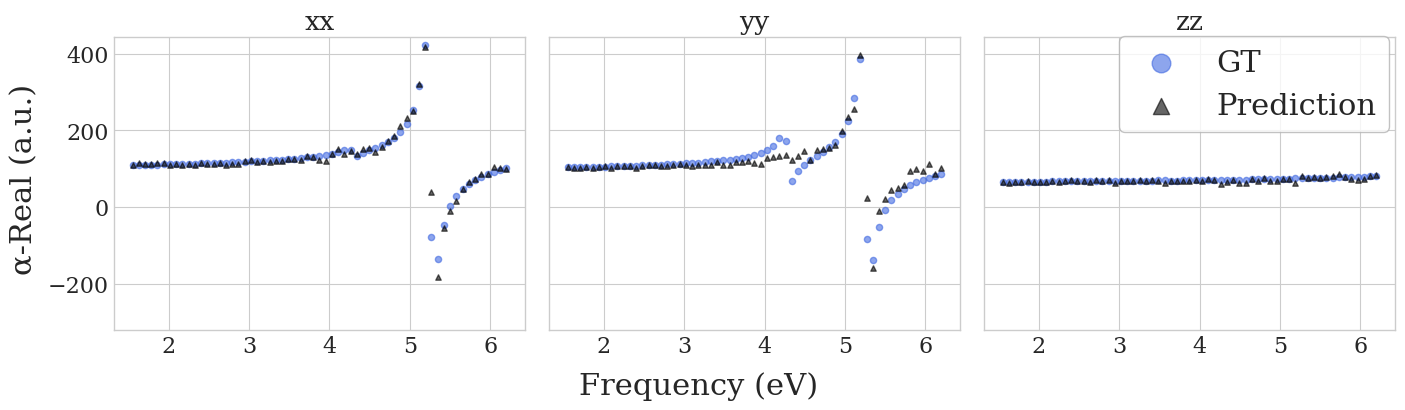

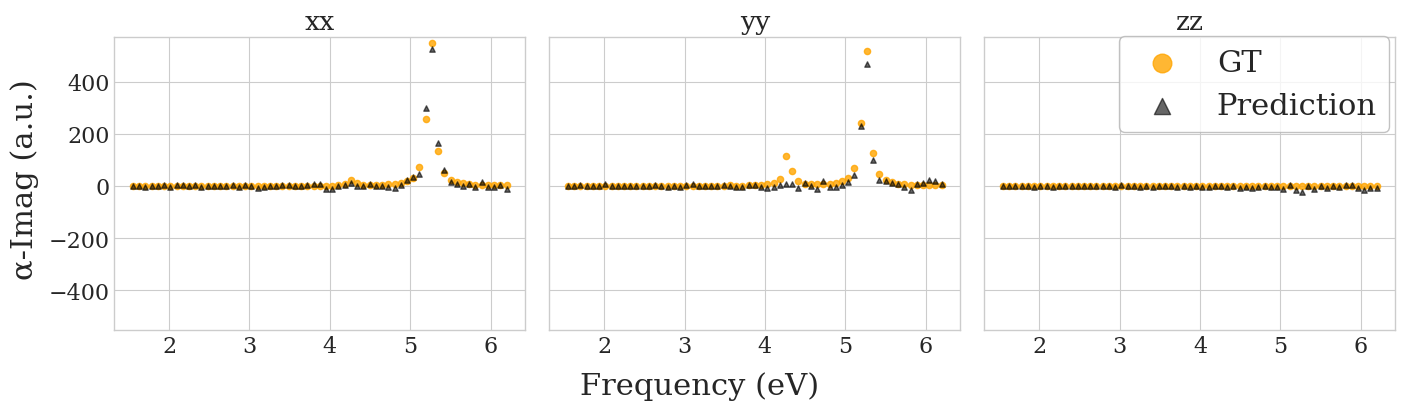

In [25]:
for i in range(1):
    data_entry = val_datasets[i]  # Assuming you want to plot the first entry
    plot_polarizability_elements(data_entry, model, out_dir="../results", save_csv=True)

Flattened samples (true) : 566568
Flattened samples (pred) : 566568


/home/maria/miniconda3/envs/pyg_conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


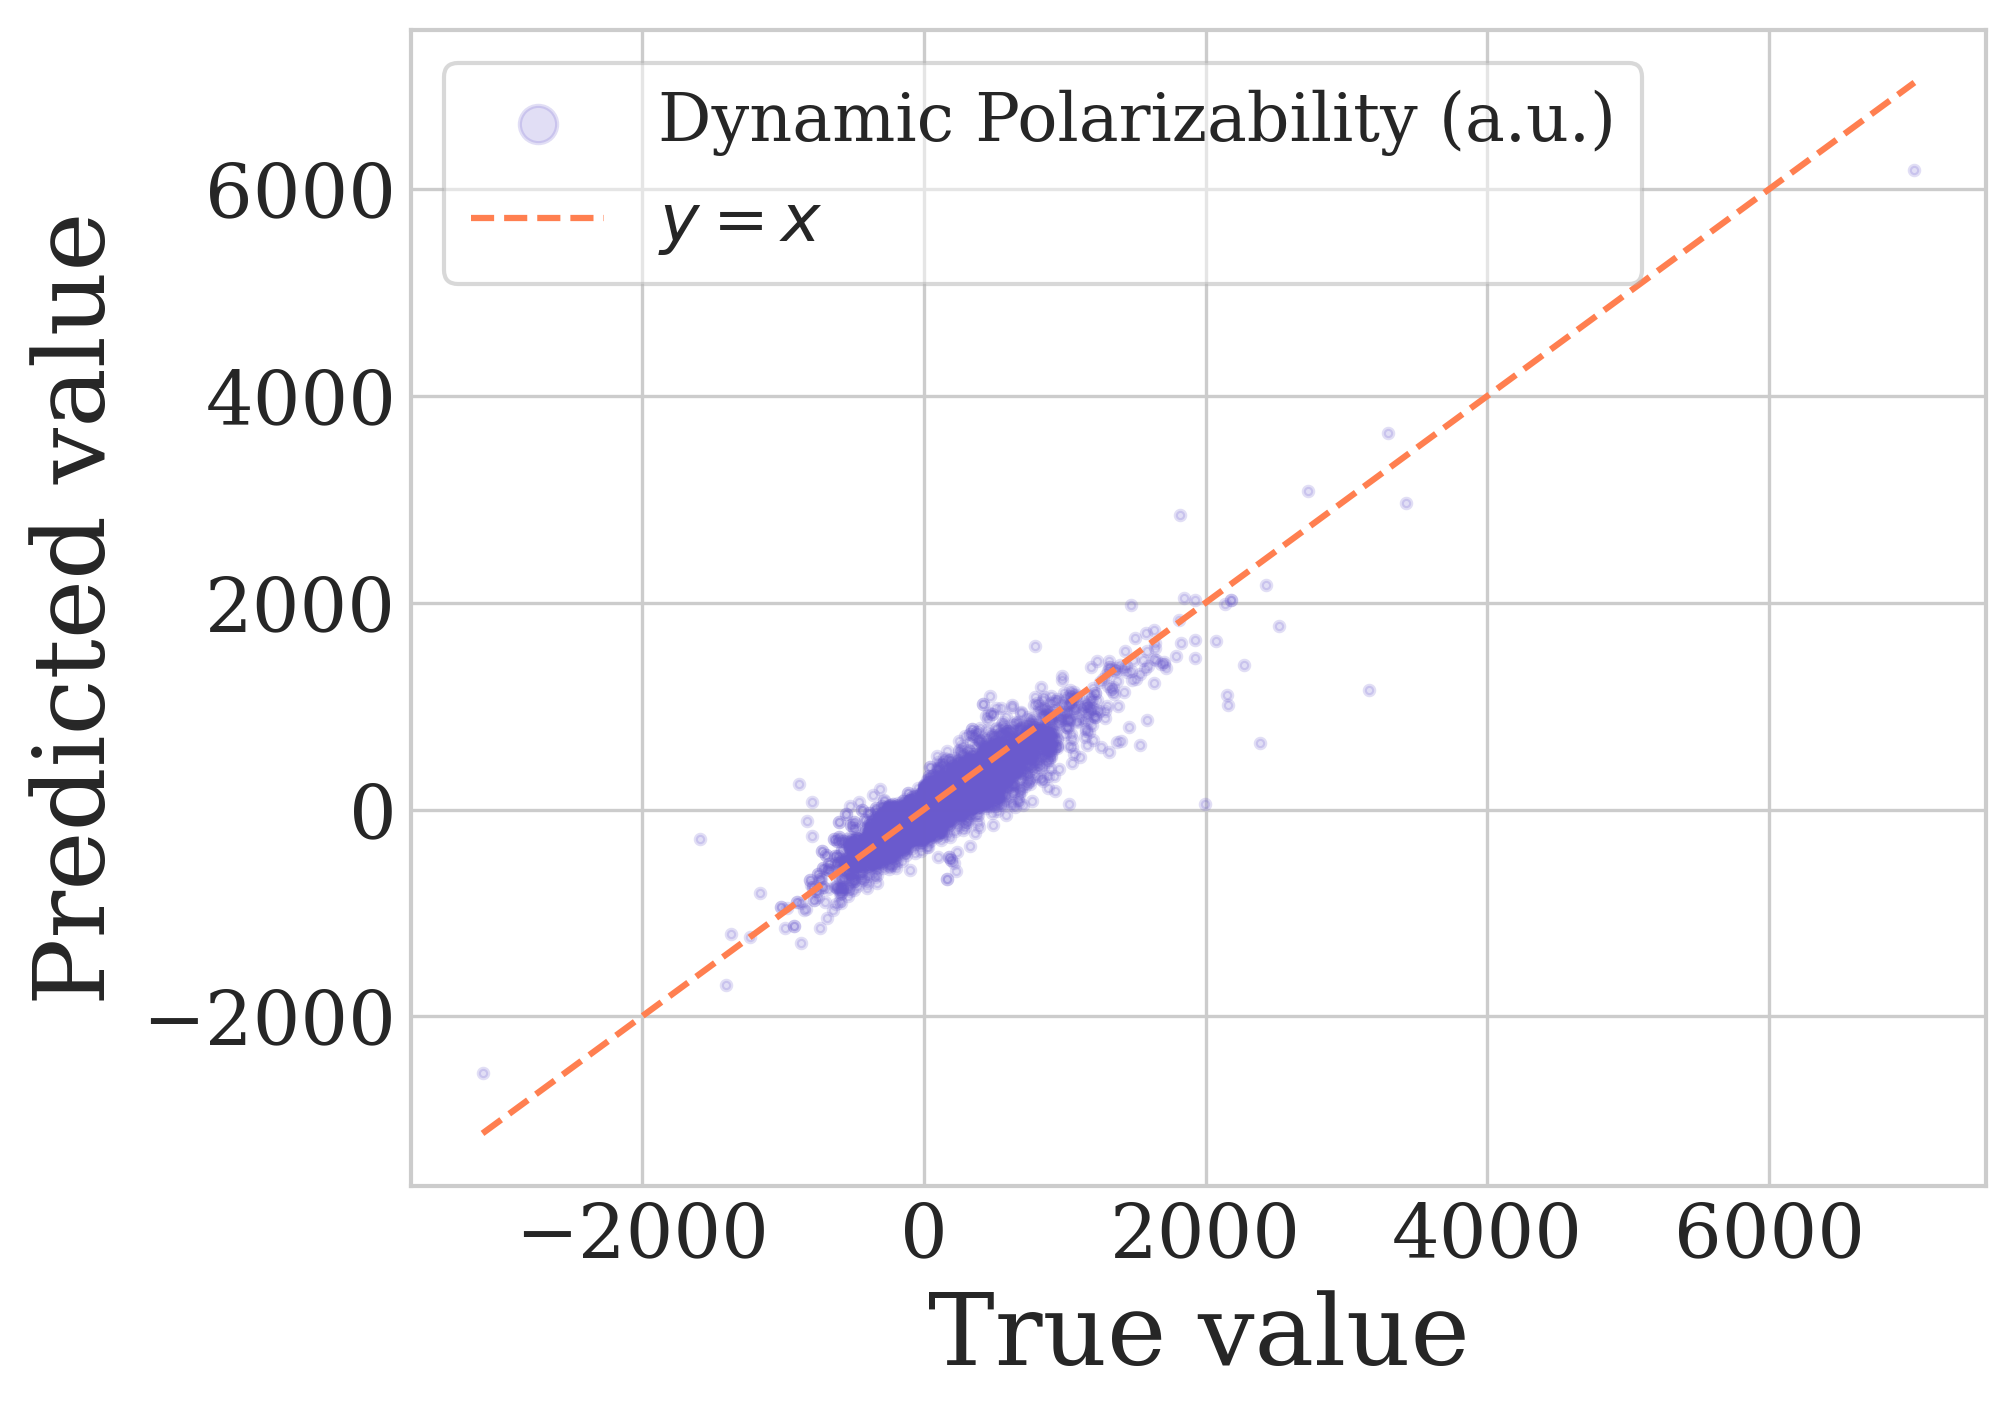

In [27]:
# ───────────────────────────────────────────────────────────────────────────────
#  Validation-set scatter plot : predicted vs. true (dynamic polarizability)
#  * aesthetics copied from the reference script *
# ───────────────────────────────────────────────────────────────────────────────
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from detanet_model import R2
from sklearn.metrics import r2_score, mean_absolute_error

plt.style.use("seaborn-v0_8-whitegrid")     # matching reference look
plt.rcParams.update({
    "font.family":      "serif",
    "font.serif":       ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,   # base text size
    "axes.labelsize":   24,   # x / y axis labels
    "axes.titlesize":   18,
    "xtick.labelsize":  18,
    "ytick.labelsize":  18,
    "legend.fontsize":  16,
})


# Prepare validation tensors  
val_dataset_plot = [data.clone() for data in val_datasets]

for d in val_dataset_plot:
    d.real_ee = d.real_ee[1:]              # drop static slice
    d.imag_ee = d.imag_ee[1:]
    d.y = torch.cat([d.real_ee, d.imag_ee], dim=0)  # shape [N, 6]

val_loader = DataLoader(val_dataset_plot, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model.to(device).eval()

true_vals, pred_vals = [], []

with torch.no_grad():
    for batch in val_loader:
        true_vals.append(batch.y.cpu().view(-1))     # flatten GT

        pred = model(                                 # predict
            z=batch.z.to(device),
            pos=batch.pos.to(device),
            x_features=batch.x.to(device)
        )

        pred_flat = pred.cpu().view(-1) if isinstance(pred, torch.Tensor) \
                   else torch.tensor(pred).view(-1)
        pred_vals.append(pred_flat)

true_vals = torch.cat(true_vals).numpy()
pred_vals = torch.cat(pred_vals).numpy()

print("Flattened samples (true) :", true_vals.size)
print("Flattened samples (pred) :", pred_vals.size)


#  Scatter plot  (aesthetics cloned from reference)
plt.figure(figsize=(7, 5), dpi=300)                           # <- same size
plt.scatter(true_vals, pred_vals,
            c="slateblue", s=5, alpha=0.2,
            label="Dynamic Polarizability (a.u.)")

vmin, vmax = min(true_vals.min(), pred_vals.min()), max(true_vals.max(),
                                                        pred_vals.max())
plt.plot([vmin, vmax], [vmin, vmax],
         "--", color="coral", label="$y=x$")

plt.xlabel("True value")          # font sizes follow rcParams
plt.ylabel("Predicted value")

plt.legend(
    frameon=True,
    facecolor="white",
    edgecolor="0.7",
    framealpha=0.5,
    markerscale=4.0               # larger legend symbols
)

plt.grid(True)
plt.tight_layout()
plt.show()

import pandas as pd
import os

out_dir = "../results"               # or wherever you want it
os.makedirs(out_dir, exist_ok=True)

pd.DataFrame(
    {"true": true_vals, "pred": pred_vals}
).to_csv(
    os.path.join(out_dir, "QM9Spol_dynamic_polarizability_pred_vs_true_scatter.csv"),
    index=False
)


# Approach 1

In [8]:
def approach_1_QM9SPol_model(device,params='trained_param/dynamic-polarizability/OPT_QM9SPol_NoSpectra0features70epochs_64batchsize_0.0005lr_6cutoff_6numblock_128features_KITQM9.pth'):
    state_dict = torch.load(params)
    model = DetaNet(num_features=128,
                    act='swish',
                    maxl=3,
                    num_block=6,
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=32,
                    rc=6.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62),
                    irreps_out='124x2e',
                    summation=True,
                    norm=False,
                    out_type='multi_tensor',
                    grad_type=None,
                    x_features=0,
                    device=device)
    model.load_state_dict(state_dict=state_dict)
    return model


qm9spol_model = approach_1_QM9SPol_model(device)

In [9]:
# ───────────────────────────────────────────────────────────────────────────────
#  Polarizability plotter (application-1) — visuals cloned from trace plotter
# ───────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_polarizability_elements_app1(data_entry, model, out_dir="."):
    """
    Plot ground-truth (GT) and predicted polarizability spectra for one molecule.
    Visually identical to the reference “trace” plotter (fonts, colours, legend
    box, etc.) but keeps the full 6-element tensor (xx, xy, …, zz) in a 1×6 grid.
    """

    # ── GLOBAL STYLE ───────────────────────────────────────────────────────────
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update({
        "font.family":      "serif",
        "font.serif":       ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
        "font.size":        16,   # tick labels & default text
        "axes.titlesize":   16,   # per-panel titles
        "axes.labelsize":   24,   # global x / y labels via fig.text
        "legend.fontsize":  22,
    })

    # ── 1.  Ground-truth tensors (unchanged) ───────────────────────────────────
    mol_idx   = data_entry.idx
    real_list = np.asarray(data_entry.real_ee)          # [N, 3, 3]  (already dyn.)
    imag_list = np.asarray(data_entry.imag_ee)

    N = real_list.shape[0]

    # ── 2.  Model prediction (unchanged) ───────────────────────────────────────
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device).eval()
    with torch.no_grad():
        pol_spec = model(
            z=data_entry.z.to(device),
            pos=data_entry.pos.to(device),
        ).cpu().numpy()                                # [N_real+N_imag, 3, 6]

    half            = pol_spec.shape[0] // 2
    pred_pol_real   = pol_spec[:half]
    pred_pol_imag   = pol_spec[half:]

    # ── 3.  Plot parameters (FULL tensor, 1×6) ────────────────────────────────
    pairs   = [(0, 0),(1, 1), (2, 2)]
    labels  = ["xx", "yy", "zz"]
    nrows, ncols = 1, 3                                    # keep 6 panels

    gt_kwargs      = dict(marker="o", color="royalblue", s=25, alpha=0.6)
    gt_kwargs_imag = dict(marker="o", color="orange",   s=25, alpha=0.8)
    pred_kwargs    = dict(marker="^", color="black",    s=22, alpha=0.6)

    rmin = min(real_list.min(), pred_pol_real.min()) - 20
    rmax = max(real_list.max(), pred_pol_real.max()) + 20
    imin = min(imag_list.min(), pred_pol_imag.min()) - 20
    imax = max(imag_list.max(), pred_pol_imag.max()) + 20

    # ── 4.  Real-part figure ───────────────────────────────────────────────────
    fig_r, axes_r = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_r[idx]
        ax.scatter(data_entry.freqs[1:], real_list[1:, i, j],          label="GT",  **gt_kwargs)
        ax.scatter(data_entry.freqs[1:], pred_pol_real[1:, i, j],      label="Prediction", **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(rmin, rmax)
        ax.grid(True)

    fig_r.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_r.text(0.05, 0.5, "α-Real (a.u.)",  ha="center", va="center",
               rotation="vertical", fontsize=22)

    handles, lbls = axes_r[0].get_legend_handles_labels()
    fig_r.legend(handles, lbls,
                 loc="upper right", bbox_to_anchor=(0.97, 0.84),
                 markerscale=3.0,
                 frameon=True, facecolor="white", edgecolor="0.70",
                 framealpha=0.8)

    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    os.makedirs(out_dir, exist_ok=True)
    fig_r.savefig(os.path.join(
        out_dir, f"polar_elements_real_{mol_idx}_{data_entry.dataset_name}.png"
    ), dpi=300)
    plt.show()
    plt.close(fig_r)

    # ── 5.  Imaginary-part figure ─────────────────────────────────────────────
    fig_i, axes_i = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_i[idx]
        ax.scatter(data_entry.freqs[1:], imag_list[1:, i, j],          label="GT",  **gt_kwargs_imag)
        ax.scatter(data_entry.freqs[1:], pred_pol_imag[1:, i, j],      label="Prediction", **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(imin, imax)
        ax.grid(True)

    fig_i.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_i.text(0.05, 0.5, "α-Imag (a.u.)",  ha="center", va="center",
               rotation="vertical", fontsize=22)

    handles_i, lbls_i = axes_i[0].get_legend_handles_labels()
    fig_i.legend(handles_i, lbls_i,
                 loc="upper right", bbox_to_anchor=(0.97, 0.84),
                 markerscale=3.0,
                 frameon=True, facecolor="white", edgecolor="0.70",
                 framealpha=0.8)

    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    fig_i.savefig(os.path.join(
        out_dir, f"polar_elements_imag_{mol_idx}_{data_entry.dataset_name}.png"
    ), dpi=300)
    plt.show()
    plt.close(fig_i)


data_emtry Data(pos=[18, 3], idx='KITQM9_70289', dataset_name='KITQM9', smiles='CC12NC1CC(C=O)=C2', z=[18], freqs=[62], spectra=[61], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[15], osc_strength=[15], y=[124, 3, 3], x=[18, 61])


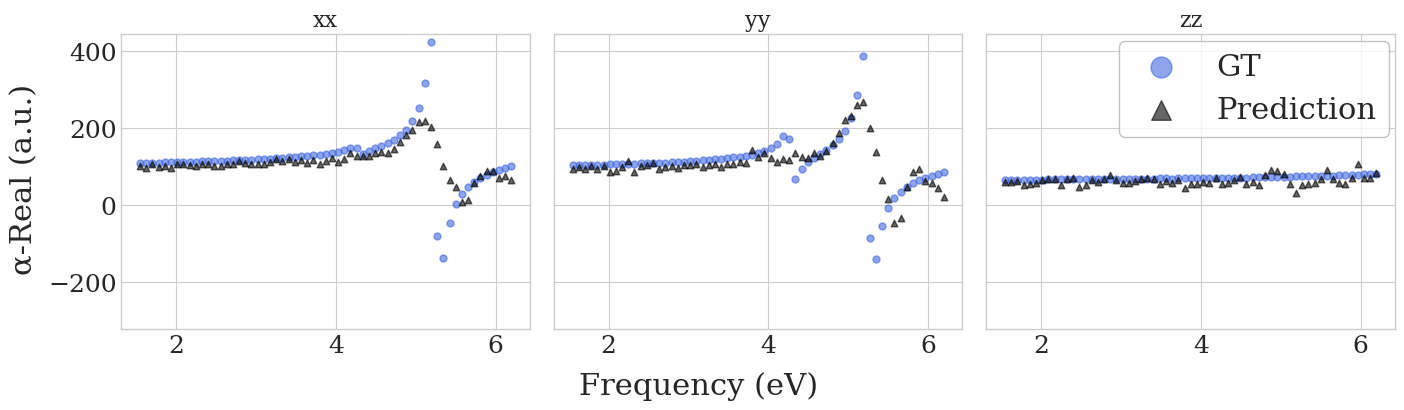

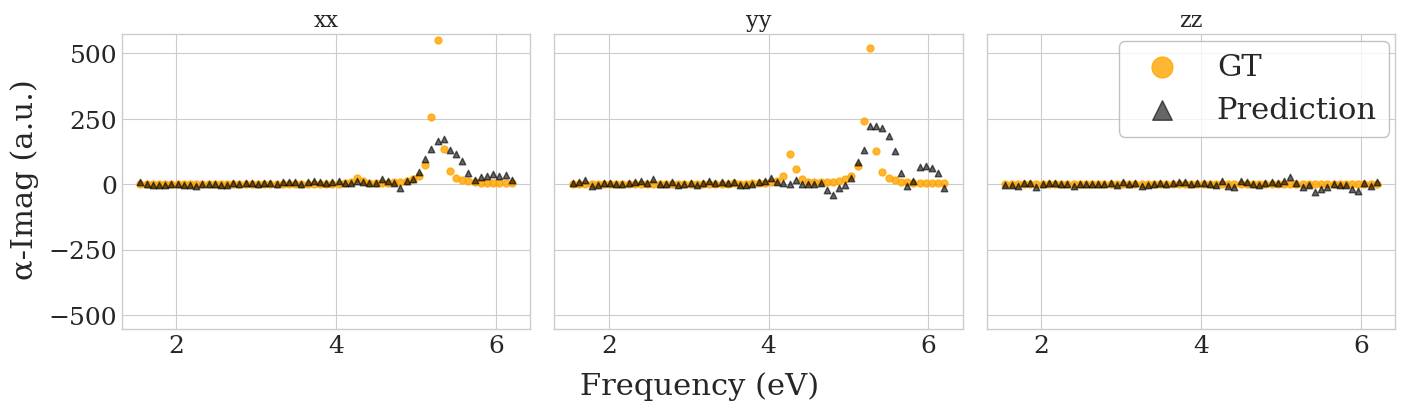

In [10]:
for i in range(1):
    data_entry = val_datasets[i]  # Assuming you want to plot the first entry
    print("data_emtry", data_entry)
    
    plot_polarizability_elements_app1(data_entry , qm9spol_model, out_dir="/home/maria/dyn-detanet/images")

Flattened samples (true) : 575856
Flattened samples (pred) : 575856


/home/maria/miniconda3/envs/pyg_conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


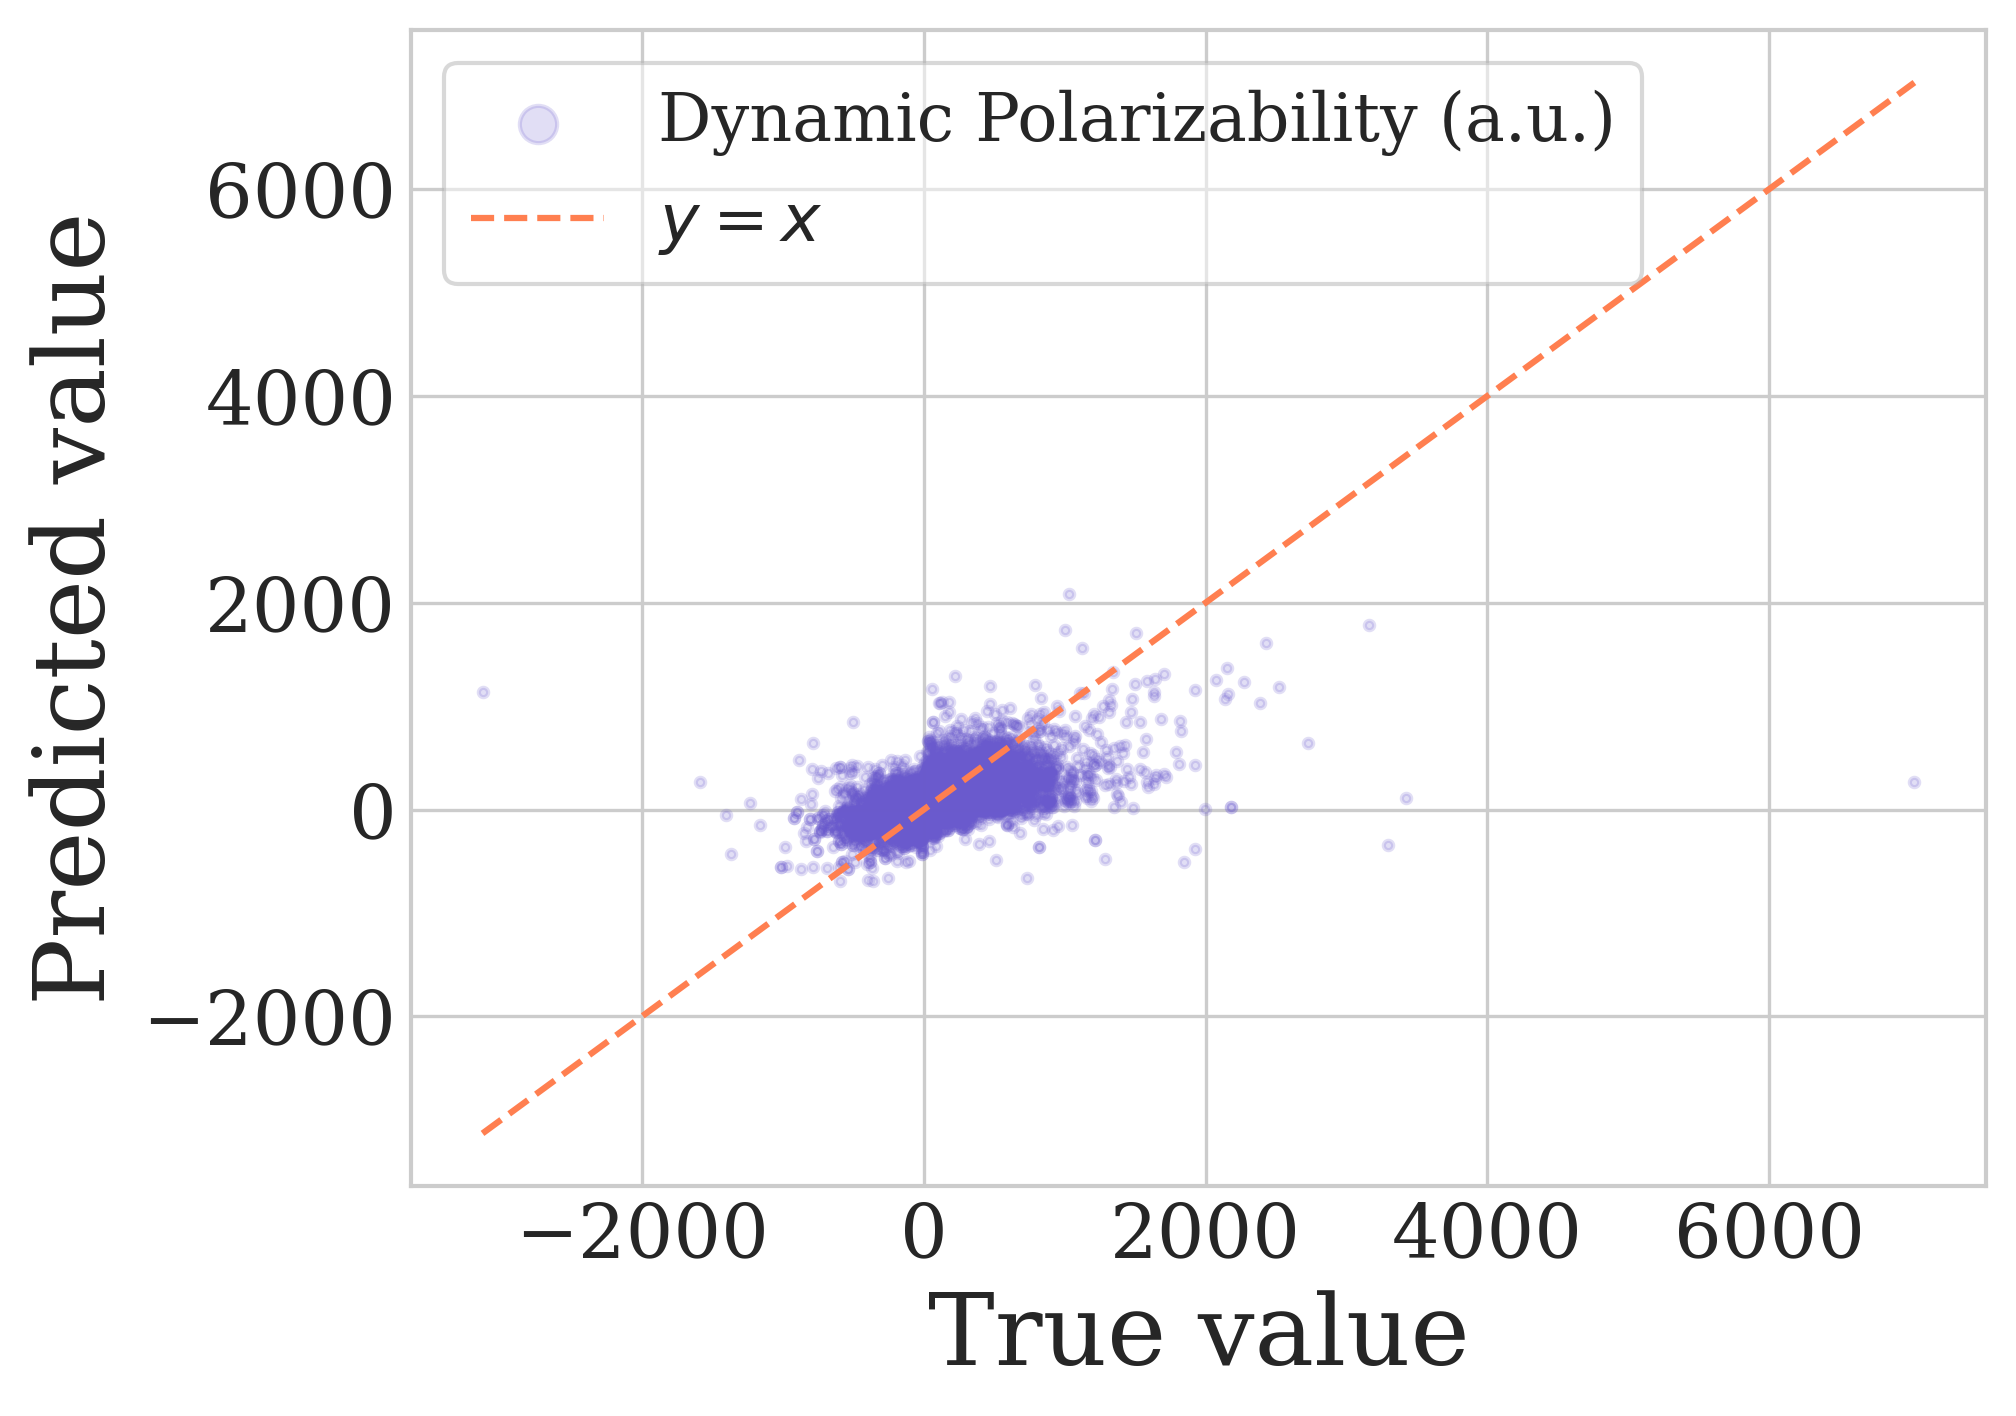

In [11]:
# ───────────────────────────────────────────────────────────────────────────────
#  Validation-set scatter plot : predicted vs. true  (dynamic polarizability)
#  –– data handling unchanged, visuals cloned from reference script ––
# ───────────────────────────────────────────────────────────────────────────────
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from detanet_model import R2
from sklearn.metrics import r2_score, mean_absolute_error

# ══════════════════════════════════════════════════════════════════════════════
# 0.  Style & fonts  (apply BEFORE any figure is created)
# ══════════════════════════════════════════════════════════════════════════════
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family":      "serif",
    "font.serif":       ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,   # base text size
    "axes.labelsize":   24,   # x / y axis labels
    "axes.titlesize":   18,
    "xtick.labelsize":  18,
    "ytick.labelsize":  18,
    "legend.fontsize":  16,
})

# ══════════════════════════════════════════════════════════════════════════════
# 1.  Gather ground-truth and predictions  (unchanged)
# ══════════════════════════════════════════════════════════════════════════════
val_loader = DataLoader(val_datasets, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = qm9spol_model.to(device).eval()

true_vals, pred_vals = [], []

with torch.no_grad():
    for batch in val_loader:
        pred = model(z=batch.z.to(device), pos=batch.pos.to(device))

        # keep only batches where GT and prediction shapes match
        if batch.y.shape == pred.shape:
            true_vals.append(batch.y.cpu().view(-1))
            pred_vals.append(pred.cpu().view(-1)
                             if isinstance(pred, torch.Tensor)
                             else torch.tensor(pred).view(-1))
        else:
            print(f"Shape mismatch: GT {batch.y.shape} vs pred {pred.shape}. Skipping.")

true_vals = torch.cat(true_vals).numpy()
pred_vals = torch.cat(pred_vals).numpy()

print("Flattened samples (true) :", true_vals.size)
print("Flattened samples (pred) :", pred_vals.size)

# ══════════════════════════════════════════════════════════════════════════════
# 2.  Scatter plot  (visuals copied from reference)
# ══════════════════════════════════════════════════════════════════════════════
plt.figure(figsize=(7, 5), dpi=300)

plt.scatter(true_vals, pred_vals,
            c="slateblue", s=5, alpha=0.2,
            label="Dynamic Polarizability (a.u.)")

vmin, vmax = min(true_vals.min(), pred_vals.min()), max(true_vals.max(), pred_vals.max())
plt.plot([vmin, vmax], [vmin, vmax],
         "--", color="coral", label="$y=x$")

plt.xlabel("True value")
plt.ylabel("Predicted value")

plt.legend(frameon=True,
           facecolor="white",
           edgecolor="0.7",
           framealpha=0.5,
           markerscale=4.0)

plt.grid(True)
plt.tight_layout()
plt.show()
